In [43]:
import numpy as np 
import pandas as pd 

### Version 1: dowload full excel

In [ ]:
import requests
from bs4 import BeautifulSoup

In [ ]:
# Function to download XLS files from a given URL
def download_xls_files_from_page(url):
    response = requests.get(url)
    response.raise_for_status()  # Check that the request was successful

    soup = BeautifulSoup(response.text, 'html.parser')
    xls_links = soup.find_all('a', href=lambda x: (x.endswith('.xls') if x else False))

    for link in xls_links:
        file_url = link['href']
        file_name = file_url.split('/')[-1]  # Extract the file name

        with requests.get(file_url, stream=True) as file_response:
            file_response.raise_for_status()
            with open(file_name, 'wb') as f:
                for chunk in file_response.iter_content(chunk_size=8192): 
                    f.write(chunk)
        print(f"Downloaded {file_name}")


In [ ]:
# Base URL and page template
base_url = 'https://usda.library.cornell.edu/concern/publications/3t945q76s'
page_param = '?locale=en&page='

# Determine the number of pages or set a high number if unknown
# You can manually set this, or dynamically find it if the number of pages is listed on the site
number_of_pages = 3  # Example number, you should set this appropriately

# Loop through all the pages
for page in range(1, number_of_pages + 1):
    page_url = f"{base_url}{page_param}{page}#release-items"
    print(f"Scraping {page_url}")
    download_xls_files_from_page(page_url)

### version 2: only download corn snd

In [3]:
import requests
from bs4 import BeautifulSoup
import xlrd
import openpyxl
from tempfile import NamedTemporaryFile

In [4]:
def download_and_extract_cells(file_url, sheet_name, cell_range):
    response = requests.get(file_url)
    response.raise_for_status()

    # Write the file temporarily to disk
    with NamedTemporaryFile(delete=False, suffix='.xls') as tmp:
        temp_file_name = tmp.name
        tmp.write(response.content)
    
    # Read the specific range from the .xls file
    book = xlrd.open_workbook(temp_file_name)
    sheet = book.sheet_by_name(sheet_name)

    data = []
    for row_idx in range(cell_range['start_row'] - 1, cell_range['end_row']):
        row_data = []
        for col_idx in range(cell_range['start_col'] - 1, cell_range['end_col']):
            row_data.append(sheet.cell_value(row_idx, col_idx))
        data.append(row_data)
    
    return data

def save_to_excel(data, output_filename):
    # Create a new Workbook
    wb = openpyxl.Workbook()
    ws = wb.active

    # Write data to Workbook
    for row_idx, row_data in enumerate(data, start=1):
        for col_idx, value in enumerate(row_data, start=1):
            ws.cell(row=row_idx, column=col_idx, value=value)
    
    # Save the workbook
    wb.save(output_filename)

In [5]:
# Specify the range and sheet name
cell_range = {'start_row': 30, 'end_row': 50, 'start_col': 1, 'end_col': 5}  # A30:E50
sheet_name = 'Page 12'

# Specify the base URL and parameters
base_url = 'https://usda.library.cornell.edu/concern/publications/3t945q76s'
page_param = '?locale=en&page='

# Specify the number of pages
number_of_pages = 2  # Adjust as needed

for page in range(1, number_of_pages + 1):
    page_url = f"{base_url}{page_param}{page}#release-items"
    soup = BeautifulSoup(requests.get(page_url).text, 'html.parser')
    xls_links = soup.find_all('a', href=lambda x: (x and x.endswith('.xls')))

    for link in xls_links:
        file_url = link['href']
        data = download_and_extract_cells(file_url, sheet_name, cell_range)
        print(data)

        # # Generate a filename for the new .xlsx file
        # file_name = file_url.split('/')[-1]
        # new_file_name = f"{file_name.split('.')[0]}_reduced.xlsx"
        
        # # Save the data to a new .xlsx file
        # save_to_excel(data, new_file_name)
        # print(f"Saved data to {new_file_name}")


[['CORN', '2021/22', '2022/23 Est.', '2023/24 Proj.', '2023/24 Proj.'], ['', '', '', 'November', 'December'], ['', '', '', 'Million Acres', ''], ['Area Planted', 93.3, 88.6, 94.9, 94.9], ['Area Harvested', 85.3, 79.1, 87.1, 87.1], ['', '', '', 'Bushels', ''], ['Yield per Harvested Acre', 176.7, 173.4, 174.9, 174.9], ['', '', '', 'Million Bushels', ''], ['Beginning Stocks', 1235.0, 1377.0, 1361.0, 1361.0], ['Production', 15074.0, 13715.0, 15234.0, 15234.0], ['Imports', 24.0, 39.0, 25.0, 25.0], ['    Supply, Total', 16333.0, 15130.0, 16621.0, 16621.0], ['Feed and Residual', 5726.0, 5549.0, 5650.0, 5650.0], ['Food, Seed & Industrial 2/', 6757.0, 6558.0, 6740.0, 6740.0], ['   Ethanol & by-products 3/', 5320.0, 5176.0, 5325.0, 5325.0], ['    Domestic, Total', 12483.0, 12108.0, 12390.0, 12390.0], ['Exports', 2472.0, 1661.0, 2075.0, 2100.0], ['    Use, Total', 14956.0, 13769.0, 14465.0, 14490.0], ['Ending Stocks', 1377.0, 1361.0, 2156.0, 2131.0], ['Avg. Farm Price ($/bu)  4/', 6.0, 6.54, 4.85

### save to datatframe instead of excel

In [146]:
import requests
from bs4 import BeautifulSoup
import xlrd
import pandas as pd
from tempfile import NamedTemporaryFile

def download_and_create_dataframe(file_url, sheet_name, header_range, data_range, date_cells):
    response = requests.get(file_url)
    response.raise_for_status()

    # Write the file temporarily to disk
    with NamedTemporaryFile(delete=False, suffix='.xls') as tmp:
        temp_file_name = tmp.name
        tmp.write(response.content)

    # Open the workbook and get the sheet
    workbook = xlrd.open_workbook(temp_file_name)
    worksheet = workbook.sheet_by_name(sheet_name)

    # Extract the date from the specified cells
    date_value = ' '.join([worksheet.cell_value(rowx, date_cells['col'] - 1) for rowx in range(date_cells['start_row'] - 1, date_cells['end_row'])])

    # Extract column headers
    headers = [worksheet.cell_value(rowx, header_range['start_col'] - 1) for rowx in range(header_range['start_row'] - 1, header_range['end_row'])]

    # Extract row data
    data_rows = [[worksheet.cell_value(rowx, data_range['start_col'] - 1) for rowx in range(data_range['start_row'] - 1, data_range['end_row'])]]

    # Prepend the date value to each row of data
    for row in data_rows:
        row.insert(0, date_value)

    # Create a DataFrame with an additional column for the date
    columns = ['Date'] + headers
    df = pd.DataFrame(data_rows, columns=columns)

    return df

# Specify the ranges and sheet name
header_range = {'start_row': 33, 'end_row': 49, 'start_col': 1}  # A33:A49 for headers
data_range = {'start_row': 33, 'end_row': 49, 'start_col': 5}    # E33:E49 for data
date_cells = {'start_row': 9, 'end_row': 10, 'col': 5}           # E9:E10 for the date

# Specify the base URL and parameters
base_url = 'https://usda.library.cornell.edu/concern/publications/3t945q76s'
page_param = '?locale=en&page='

# Specify the number of pages
number_of_pages = 10 # Adjust as needed

# List to store individual DataFrames
data_frames = []

for page in range(1, number_of_pages + 1):
    page_url = f"{base_url}{page_param}{page}#release-items"
    soup = BeautifulSoup(requests.get(page_url).text, 'html.parser')
    xls_links = soup.find_all('a', href=lambda x: (x and x.endswith('.xls')))

    for link in xls_links:
        file_url = link['href']
        df = download_and_create_dataframe(file_url, 'Page 12', header_range, data_range, date_cells)
        
        # Add the DataFrame to the list
        data_frames.append(df)

# Concatenate all the DataFrames in the list
all_data_df = pd.concat(data_frames, ignore_index=True)

In [147]:
# Removing duplicate dates, keeping only the first occurrence
all_data_df = all_data_df.drop_duplicates(subset='Date', keep='first')

In [148]:
all_data_df.head()

,Date,Area Planted,Area Harvested,,Yield per Harvested Acre,,Beginning Stocks,Production,Imports,"Supply, Total",Feed and Residual,"Food, Seed & Industrial 2/",Ethanol & by-products 3/,"Domestic, Total",Exports,"Use, Total",Ending Stocks,Avg. Farm Price ($/bu) 4/
0,2023/24 Proj. Dec,94.9,87.1,,174.9,,1361.0,15234.0,25.0,16621.0,5650.0,6740.0,5325.0,12390.0,2100.0,14490.0,2131.0,4.85
1,2023/24 Proj. Nov,94.9,87.1,,174.9,,1361.0,15234.0,25.0,16621.0,5650.0,6740.0,5325.0,12390.0,2075.0,14465.0,2156.0,4.85
2,2023/24 Proj. Oct,94.9,87.1,,173.0,,1361.0,15064.0,25.0,16451.0,5600.0,6715.0,5300.0,12315.0,2025.0,14340.0,2111.0,4.95
3,2023/24 Proj. Sep,94.9,87.1,,173.8,,1452.0,15134.0,25.0,16611.0,5625.0,6715.0,5300.0,12340.0,2050.0,14390.0,2221.0,4.9
4,2023/24 Proj. Aug,94.1,86.3,,175.1,,1457.0,15111.0,25.0,16592.0,5625.0,6715.0,5300.0,12340.0,2050.0,14390.0,2202.0,4.9


In [150]:
all_data_df.to_csv("wasde_data.csv")

### clean data

In [281]:
df = pd.read_csv("wasde_data.csv")

In [282]:
# check for missing data
df.isna().sum()

Unnamed: 0                      0
Date                            0
Area Planted                    0
Area Harvested                  0
Unnamed: 4                     97
Yield per Harvested Acre        0
Unnamed: 6                     97
Beginning Stocks                0
Production                      0
Imports                         0
    Supply, Total               0
Feed and Residual               0
Food, Seed & Industrial 2/      0
   Ethanol & by-products 3/     0
    Domestic, Total             0
Exports                         0
    Use, Total                  0
Ending Stocks                   0
Avg. Farm Price ($/bu)  4/      0
dtype: int64

In [283]:
# Remove columns that have 'Unnamed' in their name
df_cleaned = df.loc[:, ~df.columns.str.contains('Unnamed')]

In [284]:
# Renaming columns 
df_cleaned = df_cleaned.rename(columns={
    'Date': 'Date',
    'Area Planted': 'Area_Planted',
    'Area Harvested': 'Area_Harvested',
    'Yield per Harvested Acre': 'Yield_per_Acre',
    'Beginning Stocks': 'Beginning_Stocks',
    'Production': 'Production',
    'Imports': 'Imports',
    '    Supply, Total': 'Total_Supply',
    'Feed and Residual': 'Feed_and_Residual',
    'Food, Seed & Industrial 2/': 'Food_Seed_and_Industrial_Use',
    '   Ethanol & by-products 3/': 'Ethanol_and_By_products',
    '    Domestic, Total': 'Total_Domestic_Use',
    'Exports': 'Exports',
    '    Use, Total': 'Total_Use',
    'Ending Stocks': 'Ending_Stocks',
    'Avg. Farm Price ($/bu)  4/': 'Avg_Farm_Price'
})

In [285]:
df_cleaned.head()

,Date,Area_Planted,Area_Harvested,Yield_per_Acre,Beginning_Stocks,Production,Imports,Total_Supply,Feed_and_Residual,Food_Seed_and_Industrial_Use,Ethanol_and_By_products,Total_Domestic_Use,Exports,Total_Use,Ending_Stocks,Avg_Farm_Price
0,2023/24 Proj. Dec,94.9,87.1,174.9,1361.0,15234.0,25.0,16621.0,5650.0,6740.0,5325.0,12390.0,2100.0,14490.0,2131.0,4.85
1,2023/24 Proj. Nov,94.9,87.1,174.9,1361.0,15234.0,25.0,16621.0,5650.0,6740.0,5325.0,12390.0,2075.0,14465.0,2156.0,4.85
2,2023/24 Proj. Oct,94.9,87.1,173.0,1361.0,15064.0,25.0,16451.0,5600.0,6715.0,5300.0,12315.0,2025.0,14340.0,2111.0,4.95
3,2023/24 Proj. Sep,94.9,87.1,173.8,1452.0,15134.0,25.0,16611.0,5625.0,6715.0,5300.0,12340.0,2050.0,14390.0,2221.0,4.9
4,2023/24 Proj. Aug,94.1,86.3,175.1,1457.0,15111.0,25.0,16592.0,5625.0,6715.0,5300.0,12340.0,2050.0,14390.0,2202.0,4.9


In [286]:
# Convert Numerical Columns
# Function to clean numeric values and remove asterisks or other non-numeric characters
def clean_numeric(x):
    try:
        return pd.to_numeric(x.replace('*', '').strip())
    except ValueError:
        return pd.NA

# Apply the cleaning function to all columns except 'Date'
for col in df_cleaned.columns:
    if col not in ['Date']:
        df_cleaned[col] = df_cleaned[col].astype(str).apply(clean_numeric)

In [287]:
df_cleaned

,Date,Area_Planted,Area_Harvested,Yield_per_Acre,Beginning_Stocks,Production,Imports,Total_Supply,Feed_and_Residual,Food_Seed_and_Industrial_Use,Ethanol_and_By_products,Total_Domestic_Use,Exports,Total_Use,Ending_Stocks,Avg_Farm_Price
0,2023/24 Proj. Dec,94.9,87.1,174.9,1361.0,15234.0,25.0,16621.0,5650.0,6740.0,5325.0,12390.0,2100.0,14490.0,2131.0,4.85
1,2023/24 Proj. Nov,94.9,87.1,174.9,1361.0,15234.0,25.0,16621.0,5650.0,6740.0,5325.0,12390.0,2075.0,14465.0,2156.0,4.85
2,2023/24 Proj. Oct,94.9,87.1,173.0,1361.0,15064.0,25.0,16451.0,5600.0,6715.0,5300.0,12315.0,2025.0,14340.0,2111.0,4.95
3,2023/24 Proj. Sep,94.9,87.1,173.8,1452.0,15134.0,25.0,16611.0,5625.0,6715.0,5300.0,12340.0,2050.0,14390.0,2221.0,4.9
4,2023/24 Proj. Aug,94.1,86.3,175.1,1457.0,15111.0,25.0,16592.0,5625.0,6715.0,5300.0,12340.0,2050.0,14390.0,2202.0,4.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92,2015/16 Proj. Mar,88.0,80.7,168.4,1731.0,13601.0,50.0,15382.0,5300.0,6595.0,5225.0,11895.0,1650.0,13545.0,1837.0,NaN
93,2015/16 Proj. Feb,88.0,80.7,168.4,1731.0,13601.0,50.0,15382.0,5300.0,6595.0,5225.0,11895.0,1650.0,13545.0,1837.0,NaN
94,2015/16 Proj. Jan,88.0,80.7,168.4,1731.0,13601.0,40.0,15372.0,5300.0,6570.0,5200.0,11870.0,1700.0,13570.0,1802.0,NaN
95,2015/16 Proj. Dec,88.4,80.7,169.3,1731.0,13654.0,30.0,15415.0,5300.0,6580.0,5200.0,11880.0,1750.0,13630.0,1785.0,NaN


In [288]:
# get a datetime column
from datetime import datetime

# Function to convert the strings into datetime objects
def convert_to_date(string):
    year, month_str = string.split(" Proj. ")
    # Since the year is in the format "2023/24", we'll take the first year for simplicity
    year = year.split("/")[0]
    # Convert month string to a datetime object and format it
    date = datetime.strptime(f"{year} {month_str}", "%Y %b")
    return date

# Apply the function to the DataFrame
df_cleaned['projected_dates'] = df_cleaned['Date'].apply(convert_to_date)

In [289]:
# the dates show projection for a specific marketing year and projections start in May so create
# a column that highlights what number prediction and for which marketing year

# Function to adjust the month to the marketing year
def adjust_month_to_marketing_year(month):
    # May as the first month, June as second, and so forth
    return (month - 5) % 12 + 1

# Apply the functions to adjust the year and month
df_cleaned['Adjusted_Year'] = df_cleaned['projected_dates'].dt.year
df_cleaned['Adjusted_Month'] = df_cleaned['projected_dates'].dt.month.apply(adjust_month_to_marketing_year)

# Create a column for the adjusted year and month
df_cleaned['Marketing_Year_Month'] = df_cleaned.apply(lambda row: datetime(year=row['Adjusted_Year'], 
                                                                month=row['Adjusted_Month'], 
                                                                day=1), axis=1)

In [290]:
df_cleaned.to_csv("cleaned_data.csv")

### explore data

In [291]:
import pandas as pd
df_cleaned = pd.read_csv("cleaned_data.csv")

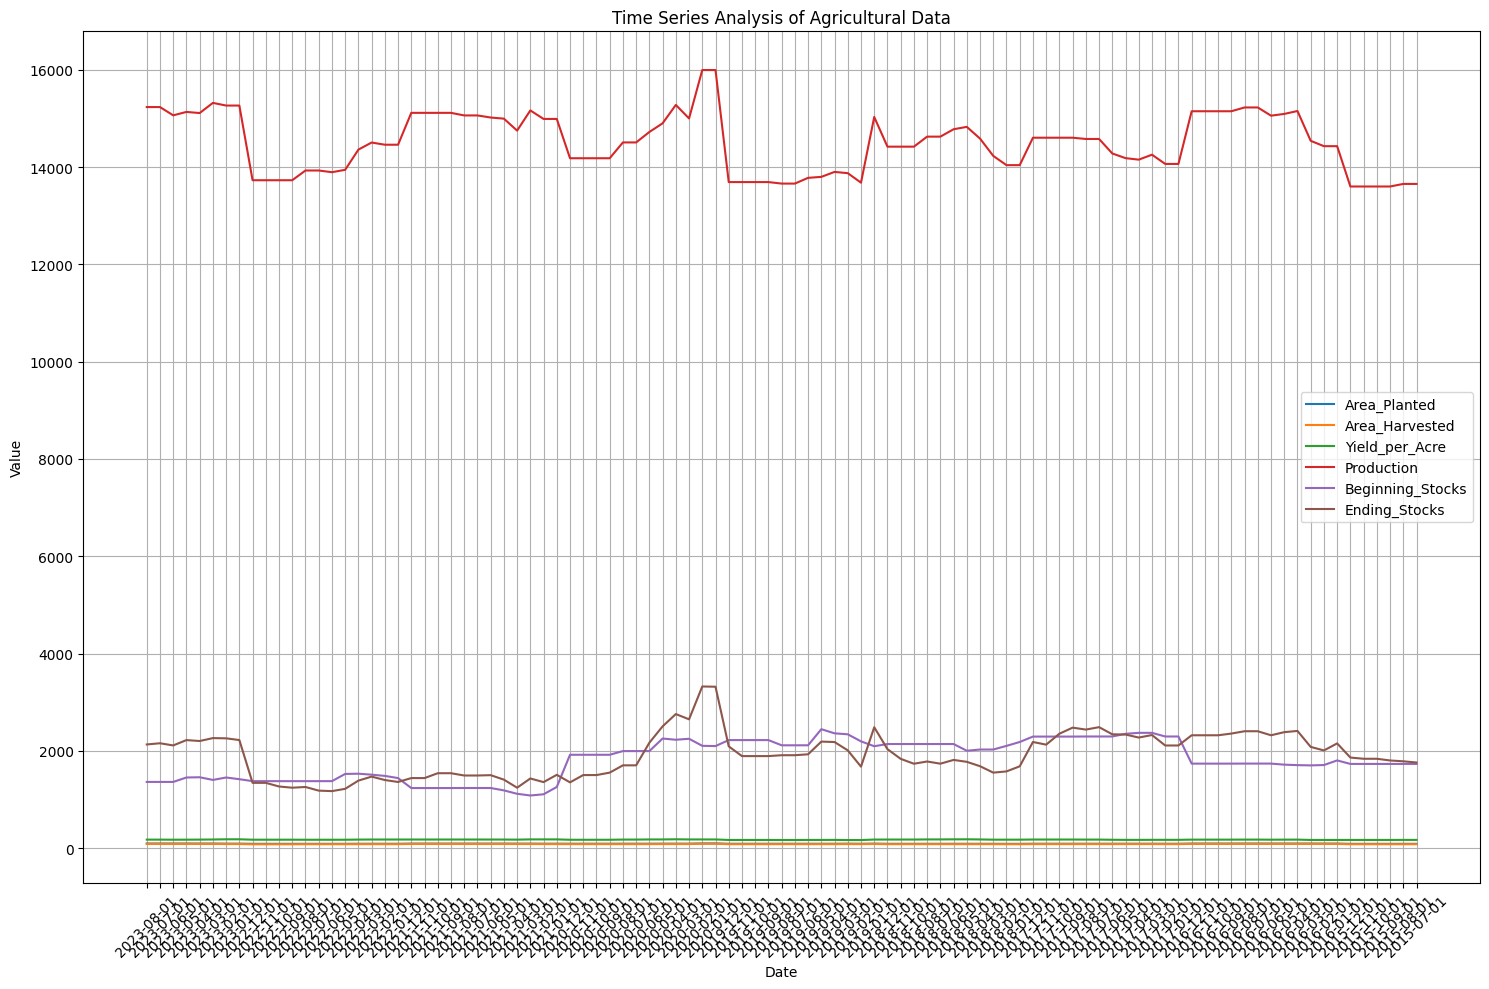

In [292]:
import matplotlib.pyplot as plt
import seaborn as sns

# Selecting key variables 
variables_to_plot = ['Area_Planted', 'Area_Harvested','Yield_per_Acre', 'Production', 'Beginning_Stocks', 'Ending_Stocks']

# Plotting time series for selected variables 
plt.figure(figsize=(15, 10))
for variable in variables_to_plot:
    sns.lineplot(data=df_cleaned, x='Marketing_Year_Month', y=variable, label=variable)

plt.title('Time Series Analysis of Agricultural Data')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

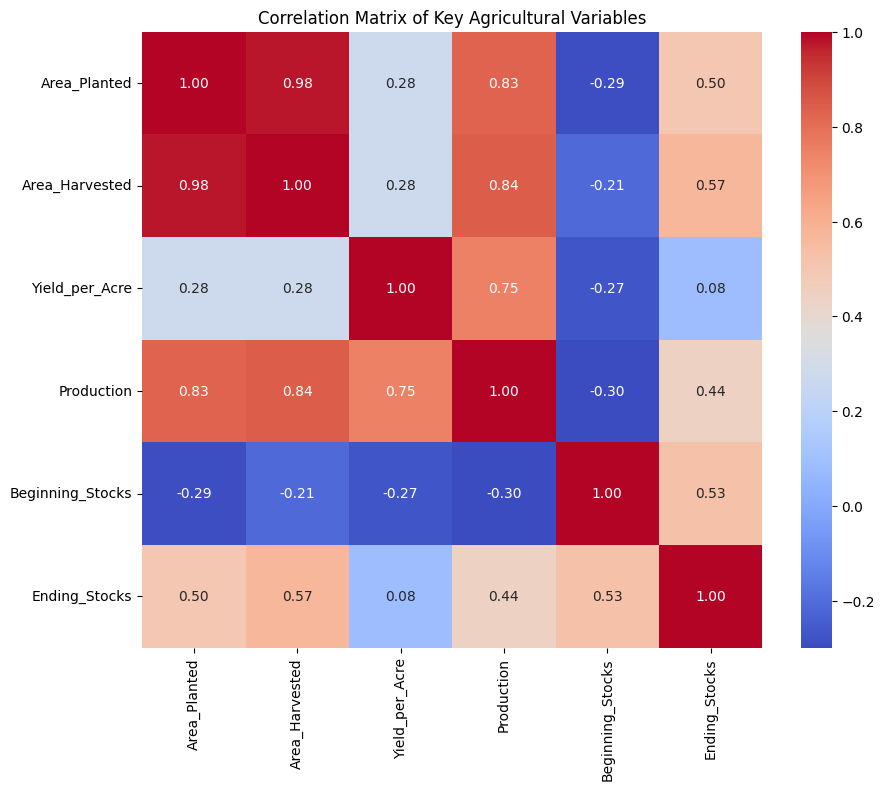

In [293]:
# Correlation analysis
correlation_matrix = df_cleaned[variables_to_plot].corr()

# Plotting the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Key Agricultural Variables')
plt.show()


<Figure size 1500x800 with 0 Axes>

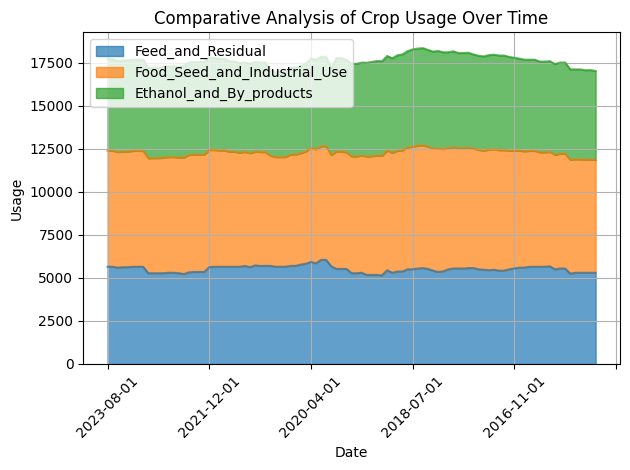

In [294]:
# Selecting usage variables for comparative analysis
usage_variables = ['Feed_and_Residual', 'Food_Seed_and_Industrial_Use','Ethanol_and_By_products']

# Preparing the data for stacked area chart
usage_data = df_cleaned[['Marketing_Year_Month'] + usage_variables].set_index('Marketing_Year_Month')

# Plotting stacked area chart
plt.figure(figsize=(15, 8))
usage_data.plot(kind='area', stacked=True, alpha=0.7)
plt.title('Comparative Analysis of Crop Usage Over Time')
plt.ylabel('Usage')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()


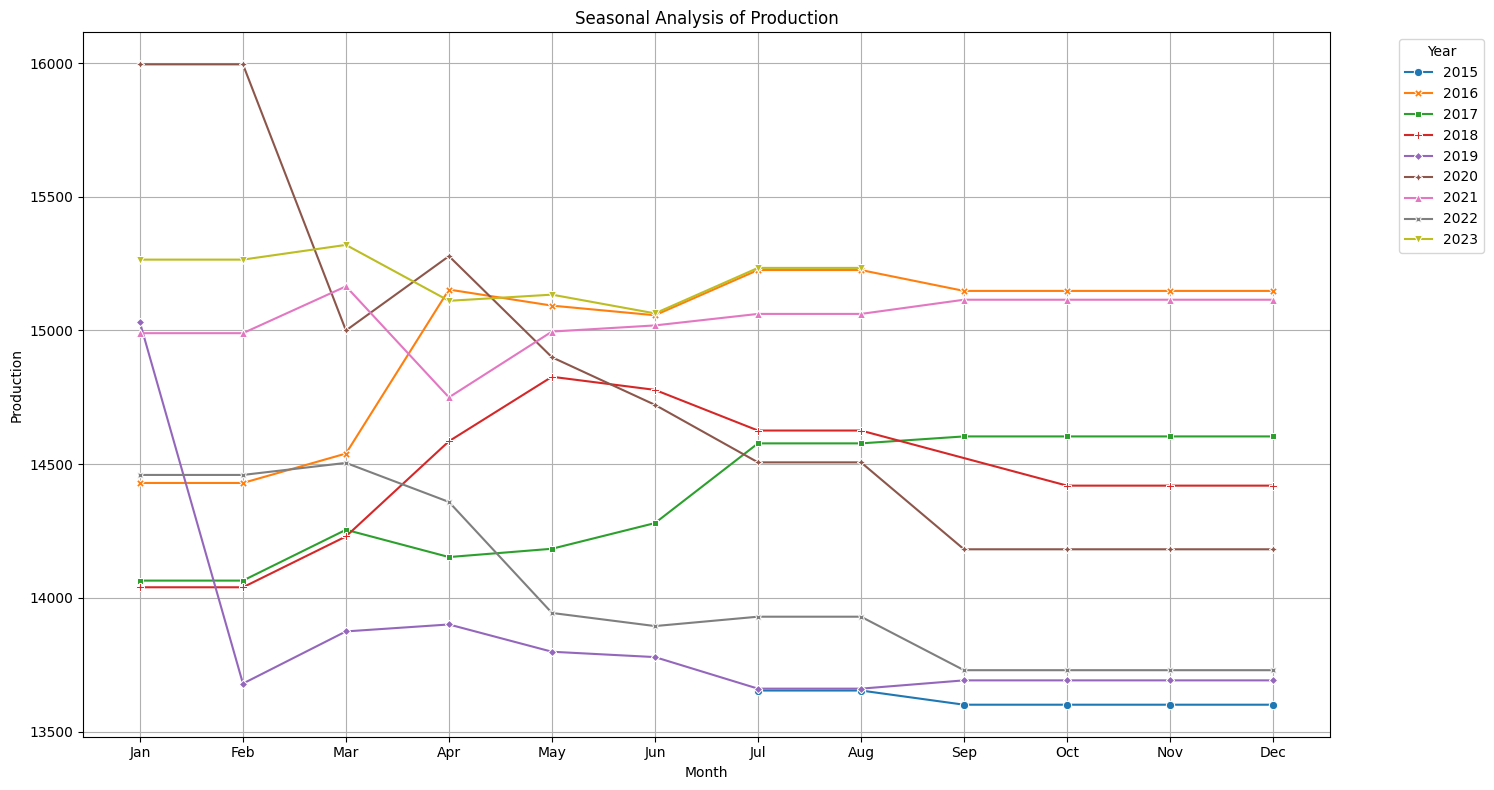

In [295]:
import matplotlib.dates as mdates

# Extracting month and year for seasonal analysis
df_cleaned['Marketing_Year_Month'] = pd.to_datetime(df_cleaned['Marketing_Year_Month'])
df_cleaned['Year'] = df_cleaned['Marketing_Year_Month'].dt.year
df_cleaned['Month'] = df_cleaned['Marketing_Year_Month'].dt.month

# Selecting a variable for seasonal analysis - let's choose 'Production'
seasonal_variable = 'Production'

# Let's create a pivot table for a clearer month-wise comparison across years
pivot_seasonal = df_cleaned.pivot_table(index='Month', columns='Year', values=seasonal_variable)

# Plotting the revised seasonal trends
plt.figure(figsize=(15, 8))
sns.lineplot(data=pivot_seasonal, markers=True, dashes=False)
plt.title('Seasonal Analysis of Production')
plt.xlabel('Month')
plt.ylabel(seasonal_variable)
plt.legend(title='Year', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.tight_layout()
plt.show()

### Build simple arima models

In [326]:
import pandas as pd
df_cleaned = pd.read_csv("cleaned_data.csv")

In [327]:
# Convert the 'projected_dates' column to datetime for accurate sorting
df_cleaned['projected_dates'] = pd.to_datetime(df_cleaned['projected_dates'], errors='coerce')

In [329]:
# train on all data apart from most recent wasde report
# Removing the most recent row
most_recent = df_cleaned.iloc[0]
df_cleaned = df_cleaned.iloc[1:]

### Lets start by looking at imports

In [332]:
# focus on imports column
imports_data = df_cleaned[['Marketing_Year_Month', 'Imports']].copy()

imports_data['Marketing_Year_Month'] = pd.to_datetime(imports_data['Marketing_Year_Month'], errors='coerce')
# Sort the data based on dates
imports_data = imports_data.sort_values(by='Marketing_Year_Month')

In [333]:
# Set the index
imports_data.set_index('Marketing_Year_Month', inplace=True)

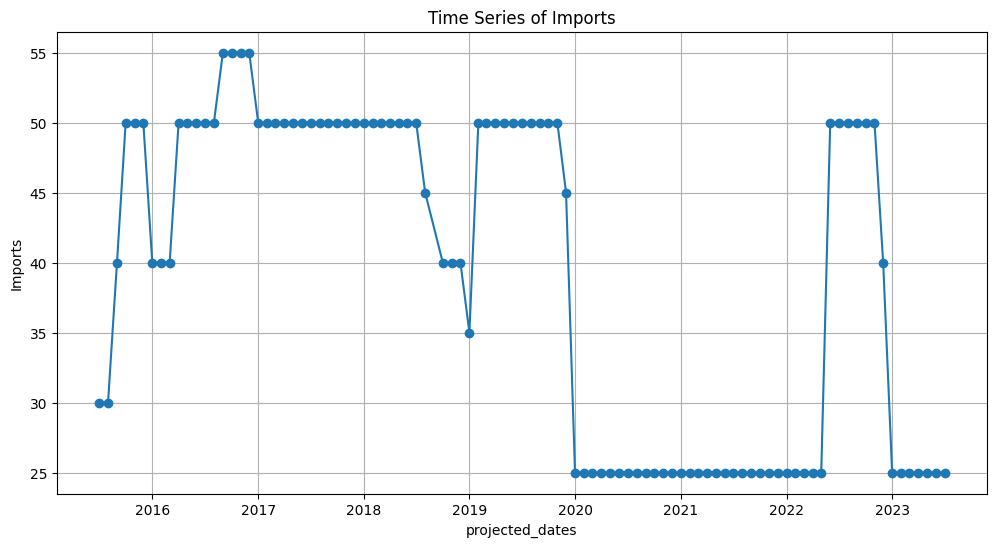

In [334]:
# Plotting the time series
plt.figure(figsize=(12, 6))
plt.plot(imports_data, marker='o')
plt.title('Time Series of Imports')
plt.xlabel('projected_dates')
plt.ylabel('Imports')
plt.grid(True)
plt.show()

In [335]:
# Performing the Augmented Dickey-Fuller test to check for stationarity
from statsmodels.tsa.stattools import adfuller
adf_test = adfuller(imports_data['Imports'])

# Display the ADF test results
adf_test_result = pd.Series(adf_test[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key, value in adf_test[4].items():
    adf_test_result[f'Critical Value ({key})'] = value

adf_test_result

Test Statistic                 -1.850416
p-value                         0.355734
#Lags Used                      0.000000
Number of Observations Used    95.000000
Critical Value (1%)            -3.501137
Critical Value (5%)            -2.892480
Critical Value (10%)           -2.583275
dtype: float64

p value greater than 0.05 so not stationary therefore we look to difference the data. We look at a simple diff but if there was seasonality in the data, we might need to difference the data at the lag equal to the season's length.

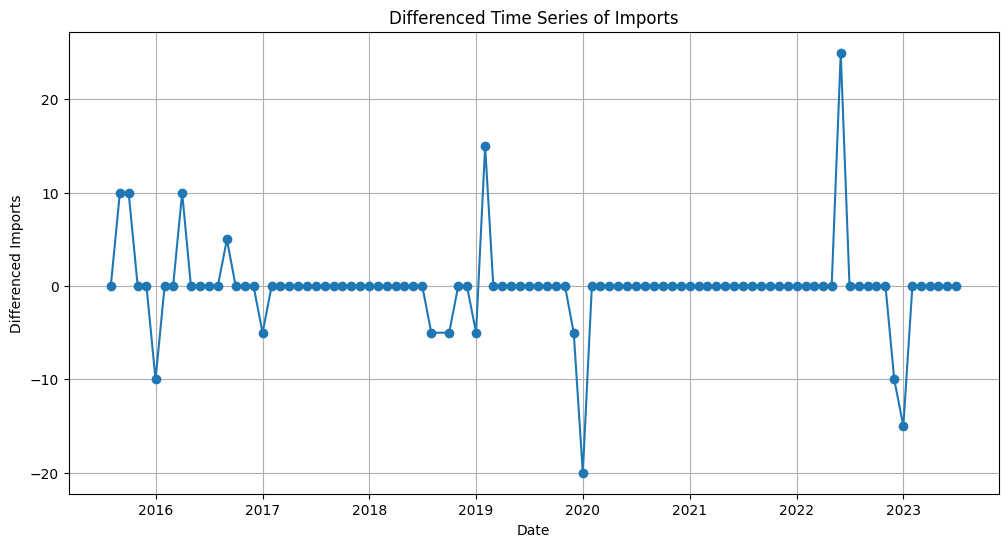

In [336]:

# Differencing the series
imports_diff = imports_data['Imports'].diff()

# Removing NaN values created by differencing
imports_diff = imports_diff.dropna()

# Plotting the differenced series
plt.figure(figsize=(12, 6))
plt.plot(imports_diff, marker='o')
plt.title('Differenced Time Series of Imports')
plt.xlabel('Date')
plt.ylabel('Differenced Imports')
plt.grid(True)
plt.show()


In [337]:
# Performing the Augmented Dickey-Fuller test again on the differenced series
adf_test_diff = adfuller(imports_diff)

# Display the ADF test results for the differenced series
adf_test_result_diff = pd.Series(adf_test_diff[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key, value in adf_test_diff[4].items():
    adf_test_result_diff[f'Critical Value ({key})'] = value

adf_test_result_diff

Test Statistic                -8.321797e+00
p-value                        3.556188e-13
#Lags Used                     0.000000e+00
Number of Observations Used    9.400000e+01
Critical Value (1%)           -3.501912e+00
Critical Value (5%)           -2.892815e+00
Critical Value (10%)          -2.583454e+00
dtype: float64

The test statistic is lower than all the critical values, and the p-value is significantly low. This indicates that the differenced series is stationary.
With the differenced series now appearing to be stationary, it is more suitable for time series forecasting models that assume stationarity, such as ARIMA.
Remember that differencing is a transformation, and any forecasts made on the differenced data will need to be "undifferenced" or integrated back to be interpretable in the original scale.

Lets look into identifying the models

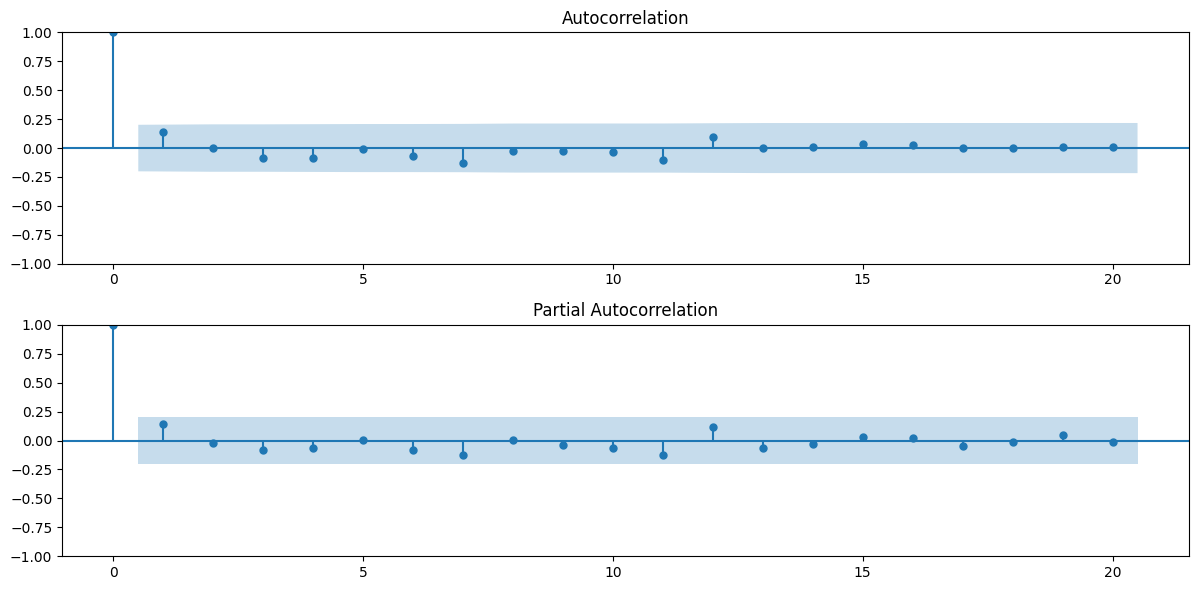

In [338]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plotting the ACF and PACF plots
plt.figure(figsize=(12, 6))

# ACF plot
plt.subplot(211)
plot_acf(imports_diff, ax=plt.gca(), lags=20)

# PACF plot
plt.subplot(212)
plot_pacf(imports_diff, ax=plt.gca(), lags=20)

plt.tight_layout()
plt.show()


The PACF plot cuts off after the first lag, suggesting that a p value of 1 might be a good starting point.
The ACF plot shows a more gradual decline, but it also appears to cut off after the first lag, suggesting a q value of 1 could be suitable.
Based on these plots, you can start by fitting an ARIMA(1,1,1) model to your data. This means one lag (p=1) is used in the autoregressive part, the series has been differenced once (d=1), and one lag (q=1) is used in the moving average part.
You might want to test a few different combinations around these values to find the best fit based on AIC or BIC values.

In [339]:
from statsmodels.tsa.arima.model import ARIMA
import warnings

# Fitting an ARIMA(1,1,1) model to the differenced series
# Suppressing warnings for model fitting
warnings.filterwarnings("ignore")

model = ARIMA(imports_diff, order=(1, 1, 1))
model_fit = model.fit()

# Displaying the summary of the model
model_fit.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                Imports   No. Observations:                   95
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -281.118
Date:                Sat, 30 Dec 2023   AIC                            568.236
Time:                        13:05:15   BIC                            575.866
Sample:                             0   HQIC                           571.318
                                 - 95                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1516      0.149      1.014      0.311      -0.141       0.444
ma.L1         -0.9999     21.315     -0.047      0.963     -42.776      40.776
sigma2        22.1579    471.681      0.047      0.963    -902.319     946.635
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):               599.50
Prob(Q):                              0.87   Prob(JB):                         0.00
Heteroskedasticity (H):               2.20   Skew:                             1.07
Prob(H) (two-sided):                  0.03   Kurtosis:                        15.18
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

The coefficient for the autoregressive part is approximately 0.0191, but it is not statistically significant (p-value = 0.919).
The coefficient for the moving average part is approximately -0.9993. However, this coefficient, along with its high standard error and p-value, suggests that it might not be a good predictor.
The statistical significance of the coefficients is not strong, suggesting that this particular ARIMA(1,1,1) model may not be the best fit for the data.
The high p-values for the AR and MA components suggest that these terms are not contributing significantly to the model.
The lack of normality in residuals (as indicated by the Jarque-Bera test) might affect the model's predictive performance.
It might be beneficial to try other combinations of p, d, q values, and compare their AIC and BIC values to find a better fitting model.

In [340]:
# Trying different ARIMA configurations to find a better fitting model
# We will vary p and q from 0 to 2 and keep d as 1 since we have already differenced the series once

best_aic = float("inf")
best_bic = float("inf")
best_order = None
best_model = None

# Iterating over different values of p and q
for p in range(3):
    for q in range(3):
        try:
            # Fitting the ARIMA model
            model = ARIMA(imports_diff, order=(p, 1, q))
            model_fit = model.fit()

            # Checking if the current model has a lower AIC and BIC than the best so far
            if model_fit.aic < best_aic and model_fit.bic < best_bic:
                best_aic = model_fit.aic
                best_bic = model_fit.bic
                best_order = (p, 1, q)
                best_model = model_fit
        except:
            continue

# Displaying the best model's summary
(best_order, best_model.summary())


((0, 1, 1),
 <class 'statsmodels.iolib.summary.Summary'>
 """
                                SARIMAX Results                                
 Dep. Variable:                Imports   No. Observations:                   95
 Model:                 ARIMA(0, 1, 1)   Log Likelihood                -282.208
 Date:                Sat, 30 Dec 2023   AIC                            568.417
 Time:                        13:05:16   BIC                            573.503
 Sample:                             0   HQIC                           570.471
                                  - 95                                         
 Covariance Type:                  opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
 ------------------------------------------------------------------------------
 ma.L1         -0.9994      2.215     -0.451      0.652      -5.341       3.343
 sigma2        22.6167     49.571      0.456      0.648   

The ARIMA(0,1,1) model is a simpler model compared to ARIMA(1,1,1), as it only includes a moving average component without an autoregressive part.
Despite the statistical improvement in terms of AIC and BIC, the significance of the MA coefficient remains weak, and the residuals' normality is still a concern.
The results suggest that while this model might be the best among those tested, it may still not be an ideal fit for the data, potentially due to the inherent complexity and uncertainty in the WASDE projections.

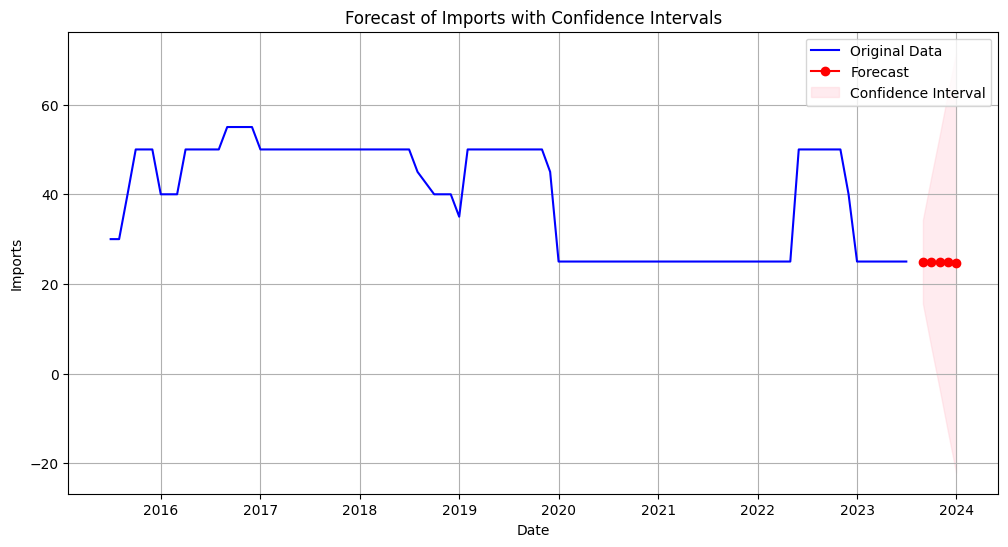

In [341]:
# Proceeding with forecasting using the best model (ARIMA(0,1,1))

# Number of steps to forecast
n_steps = 5

# Forecasting the next few steps
forecast = best_model.get_forecast(steps=n_steps)

# Extracting forecast mean and confidence intervals
forecast_mean = forecast.predicted_mean

# Correcting the approach to get the confidence intervals
confidence_intervals = forecast.conf_int()

# Integrating the forecasts back to the original scale
# The last known value of the original non-differenced 'Imports' series
last_value = imports_data['Imports'].iloc[-1]

# Integrating the forecasts
integrated_forecast = last_value + forecast_mean.cumsum()

# Integrating the confidence intervals
integrated_confidence_intervals = confidence_intervals.cumsum() + last_value

# Adjusting the forecast index to align with the original data's timeline

# Getting the last date from the original data
last_date = imports_data.index[-1]

# Generating new forecast dates starting from the day after the last date
forecast_dates = pd.date_range(start=last_date, periods=n_steps + 1, freq='M')[1:]

# Assigning the new dates to the forecast and confidence intervals
integrated_forecast.index = forecast_dates
integrated_confidence_intervals.index = forecast_dates

# Re-plotting the forecast with the corrected dates
plt.figure(figsize=(12, 6))

# Plotting the original 'Imports' data
plt.plot(imports_data['Imports'], color='blue', label='Original Data')

# Plotting the forecast
plt.plot(integrated_forecast, color='red', marker='o', label='Forecast')

# Plotting the confidence intervals
plt.fill_between(integrated_confidence_intervals.index, 
                 integrated_confidence_intervals['lower Imports'], 
                 integrated_confidence_intervals['upper Imports'], 
                 color='pink', alpha=0.3, label='Confidence Interval')

plt.title('Forecast of Imports with Confidence Intervals')
plt.xlabel('Date')
plt.ylabel('Imports')
plt.legend()
plt.grid(True)
plt.show()


In [342]:
integrated_forecast

2023-08-31    24.947225
2023-09-30    24.894451
2023-10-31    24.841676
2023-11-30    24.788902
2023-12-31    24.736127
Freq: M, Name: predicted_mean, dtype: float64

In [345]:
most_recent[['Marketing_Year_Month','projected_dates','Imports']]

Marketing_Year_Month             2023-08-01
projected_dates         2023-12-01 00:00:00
Imports                                25.0
Name: 0, dtype: object

The forecasts suggest a slight downward trend in the 'Imports' over the next five periods.
The wide confidence intervals underscore the high level of uncertainty in these predictions. This is important to consider, especially given the inherent uncertainties in projecting agricultural imports.
These forecasts and intervals should be used cautiously, especially for decision-making purposes in contexts where accurate predictions are crucial.

The ARIMA model showed limitations due to non-significant coefficients, and this could be attributed to the complexity and inherent uncertainty in WASDE data. Other approaches might be more effective in capturing the nuances of this kind of data. Here are some alternatives to consider:

SARIMA (Seasonal ARIMA):

If the data exhibits seasonality, a SARIMA model, which extends ARIMA by adding seasonal terms, could be more appropriate.
This model can handle both the non-seasonal and seasonal components of the time series.
ARIMA with Exogenous Variables (ARIMAX):

If there are external factors or variables that could influence the 'Imports' (like economic indicators, policy changes, global events), an ARIMA model that includes these exogenous variables (ARIMAX) might provide better forecasts.
Machine Learning Approaches:

Random Forests or Gradient Boosting Machines: These can handle nonlinear relationships and interactions between variables. They might be more suitable if the data has complex patterns that linear models like ARIMA cannot capture.
Neural Networks: Deep learning models, particularly LSTM (Long Short-Term Memory) networks, are well-suited for time series forecasting, especially when the series has complex patterns.
Vector Autoregression (VAR):

If you have multiple time series that influence each other (e.g., different types of agricultural data from the WASDE reports), a VAR model can capture the interdependencies among them.
Hybrid Models:

Combining statistical models with machine learning approaches can sometimes provide better results. For example, using ARIMA to model the linear aspects of the series and machine learning to capture nonlinear patterns.
Domain-Specific Models:

If there are specific agricultural or economic models known to work well with this type of data, those could be worth exploring.
Incorporate More Data:

If possible, integrating additional relevant data (like weather patterns, commodity prices, etc.) could improve the model's accuracy.

## area harvested

In [346]:
# focus on area harvested column
harvest_data = df_cleaned[['Marketing_Year_Month', 'Area_Harvested']].copy()

harvest_data['Marketing_Year_Month'] = pd.to_datetime(harvest_data['Marketing_Year_Month'], errors='coerce')
# Sort the data based on dates
harvest_data = harvest_data.sort_values(by='Marketing_Year_Month')

In [347]:
# Set the index
harvest_data.set_index('Marketing_Year_Month', inplace=True)

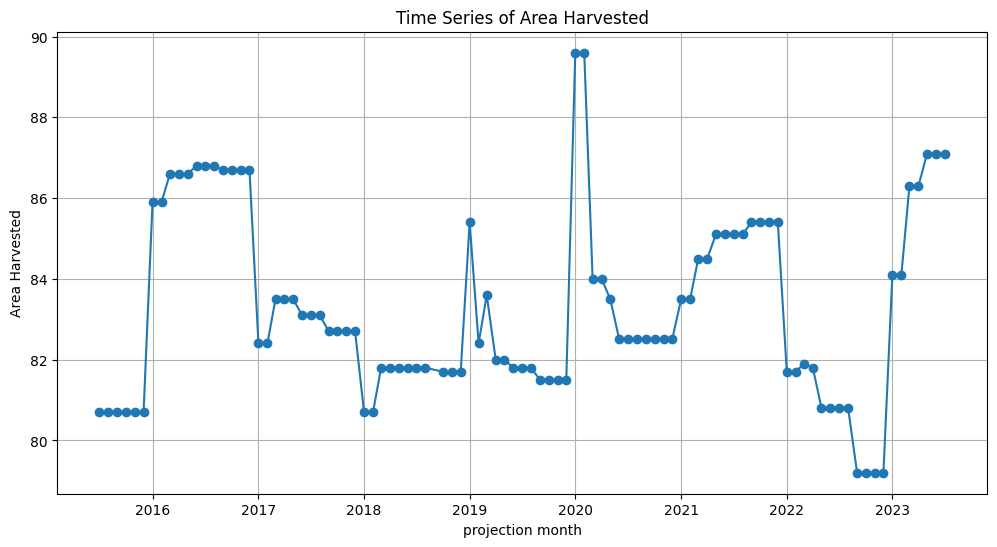

In [349]:
# Plotting the time series
plt.figure(figsize=(12, 6))
plt.plot(harvest_data, marker='o')
plt.title('Time Series of Area Harvested')
plt.xlabel('projection month')
plt.ylabel('Area Harvested')
plt.grid(True)
plt.show()

In [350]:
# Performing the Augmented Dickey-Fuller test to check for stationarity
from statsmodels.tsa.stattools import adfuller
adf_test = adfuller(harvest_data['Area_Harvested'])

# Display the ADF test results
adf_test_result = pd.Series(adf_test[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key, value in adf_test[4].items():
    adf_test_result[f'Critical Value ({key})'] = value

adf_test_result

Test Statistic                 -3.302436
p-value                         0.014770
#Lags Used                      0.000000
Number of Observations Used    95.000000
Critical Value (1%)            -3.501137
Critical Value (5%)            -2.892480
Critical Value (10%)           -2.583275
dtype: float64

p-value is actually less than 0.05 which suggests stationarity so move on to identifying model

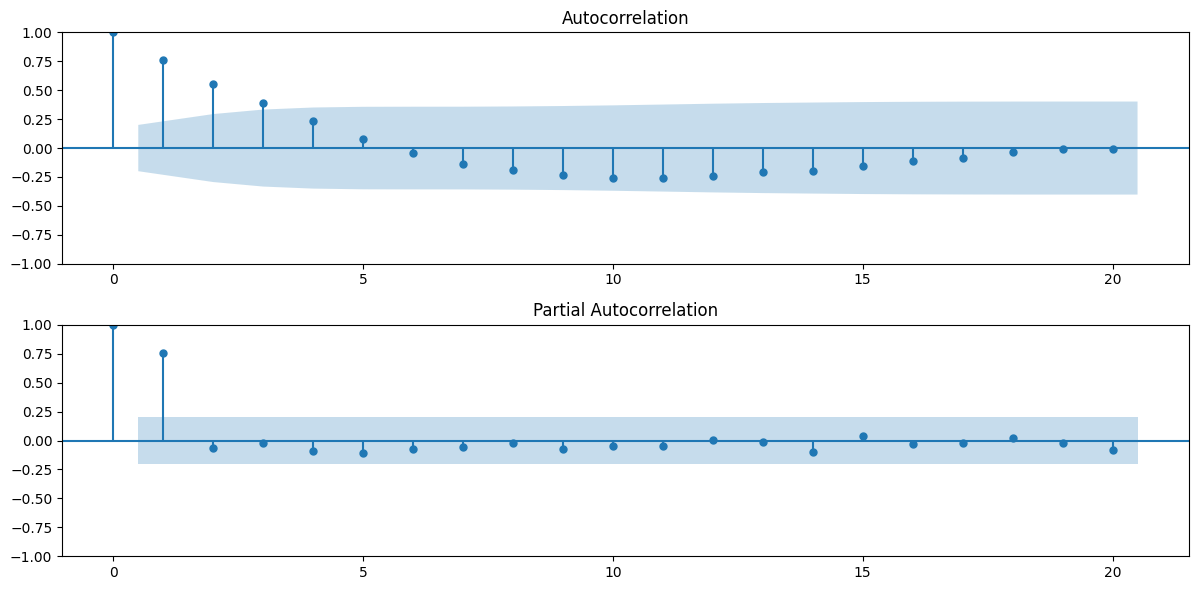

In [351]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plotting the ACF and PACF plots
plt.figure(figsize=(12, 6))

# ACF plot
plt.subplot(211)
plot_acf(harvest_data, ax=plt.gca(), lags=20)

# PACF plot
plt.subplot(212)
plot_pacf(harvest_data, ax=plt.gca(), lags=20)

plt.tight_layout()
plt.show()

In [353]:
from statsmodels.tsa.arima.model import ARIMA
import warnings

# Fitting an ARIMA(1,0,1) model to the differenced series
# Suppressing warnings for model fitting
warnings.filterwarnings("ignore")

model = ARIMA(harvest_data, order=(1, 0, 1))
model_fit = model.fit()

# Displaying the summary of the model
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:         Area_Harvested   No. Observations:                   96
Model:                 ARIMA(1, 0, 1)   Log Likelihood                -173.193
Date:                Sat, 30 Dec 2023   AIC                            354.387
Time:                        14:19:44   BIC                            364.644
Sample:                             0   HQIC                           358.533
                                 - 96                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         83.3484      0.764    109.146      0.000      81.852      84.845
ar.L1          0.7594      0.090      8.394      0.000       0.582       0.937
ma.L1          0.0619      0.183      0.337      0.736      -0.298       0.421
sigma2         2.1390      0.226      9.456      0.000       1.696       2.582
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               315.11
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.98   Skew:                             1.51
Prob(H) (two-sided):                  0.95   Kurtosis:                        11.34
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [354]:
# Trying different ARIMA configurations to find a better fitting model
# We will vary p and q from 0 to 2 and keep d as 0 since we have already differenced the series once

best_aic = float("inf")
best_bic = float("inf")
best_order = None
best_model = None

# Iterating over different values of p and q
for p in range(3):
    for q in range(3):
        try:
            # Fitting the ARIMA model
            model = ARIMA(harvest_data, order=(p, 0, q))
            model_fit = model.fit()

            # Checking if the current model has a lower AIC and BIC than the best so far
            if model_fit.aic < best_aic and model_fit.bic < best_bic:
                best_aic = model_fit.aic
                best_bic = model_fit.bic
                best_order = (p, 0, q)
                best_model = model_fit
        except:
            continue

# Displaying the best model's summary
(best_order, best_model.summary())


((1, 0, 0),
 <class 'statsmodels.iolib.summary.Summary'>
 """
                                SARIMAX Results                                
 Dep. Variable:         Area_Harvested   No. Observations:                   96
 Model:                 ARIMA(1, 0, 0)   Log Likelihood                -173.304
 Date:                Sat, 30 Dec 2023   AIC                            352.607
 Time:                        14:21:05   BIC                            360.300
 Sample:                             0   HQIC                           355.717
                                  - 96                                         
 Covariance Type:                  opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
 ------------------------------------------------------------------------------
 const         83.3529      0.799    104.262      0.000      81.786      84.920
 ar.L1          0.7843      0.074     10.575      0.000   

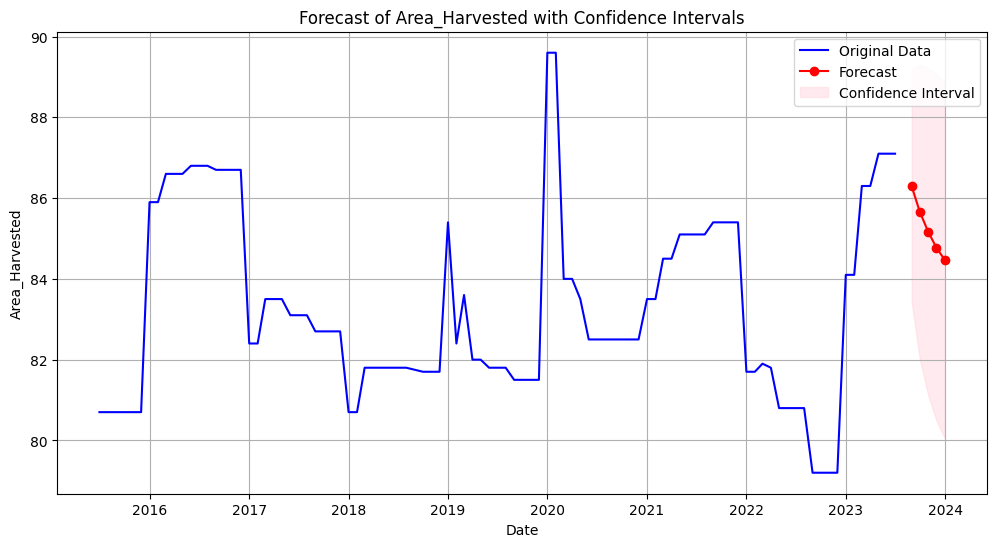

In [368]:
# Proceeding with forecasting using the best model (ARIMA(1,0,0))

# Number of steps to forecast
n_steps = 5

# Forecasting the next few steps
forecast = best_model.get_forecast(steps=n_steps)

# Extracting forecast mean and confidence intervals
forecast_mean = forecast.predicted_mean

# Correcting the approach to get the confidence intervals
confidence_intervals = forecast.conf_int()

# Adjusting the forecast index to align with the original data's timeline

# Getting the last date from the original data
last_date = harvest_data.index[-1]

# Generating new forecast dates starting from the day after the last date
forecast_dates = pd.date_range(start=last_date, periods=n_steps + 1, freq='M')[1:]

# Assigning the new dates to the forecast and confidence intervals
forecast_mean.index = forecast_dates
confidence_intervals.index = forecast_dates

# Re-plotting the forecast with the corrected dates
plt.figure(figsize=(12, 6))

# Plotting the original 'Imports' data
plt.plot(harvest_data['Area_Harvested'], color='blue', label='Original Data')

# Plotting the forecast
plt.plot(forecast_mean, color='red', marker='o', label='Forecast')

# Plotting the confidence intervals
plt.fill_between(confidence_intervals.index, 
                 confidence_intervals['lower Area_Harvested'], 
                 confidence_intervals['upper Area_Harvested'], 
                 color='pink', alpha=0.3, label='Confidence Interval')

plt.title('Forecast of Area_Harvested with Confidence Intervals')
plt.xlabel('Date')
plt.ylabel('Area_Harvested')
plt.legend()
plt.grid(True)
plt.show()


In [369]:
forecast_mean

2023-08-31    86.291782
2023-09-30    85.657891
2023-10-31    85.160726
2023-11-30    84.770796
2023-12-31    84.464971
Freq: M, Name: predicted_mean, dtype: float64

In [370]:
most_recent[['Marketing_Year_Month','projected_dates','Area_Harvested']]

Marketing_Year_Month             2023-08-01
projected_dates         2023-12-01 00:00:00
Area_Harvested                         87.1
Name: 0, dtype: object

so we underpredict area harvested

## Yield (most difficult to predict)

In [371]:
# focus on area harvested column
yield_data = df_cleaned[['Marketing_Year_Month', 'Yield_per_Acre']].copy()

yield_data['Marketing_Year_Month'] = pd.to_datetime(yield_data['Marketing_Year_Month'], errors='coerce')
# Sort the data based on dates
yield_data = yield_data.sort_values(by='Marketing_Year_Month')

In [372]:
# Set the index
yield_data.set_index('Marketing_Year_Month', inplace=True)

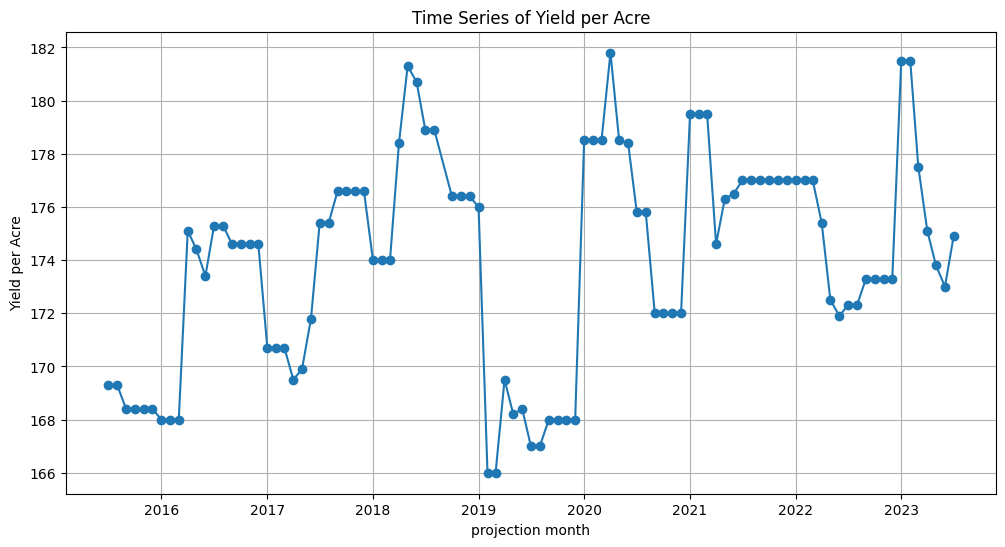

In [373]:
# Plotting the time series
plt.figure(figsize=(12, 6))
plt.plot(yield_data, marker='o')
plt.title('Time Series of Yield per Acre')
plt.xlabel('projection month')
plt.ylabel('Yield per Acre')
plt.grid(True)
plt.show()

In [375]:
# Performing the Augmented Dickey-Fuller test to check for stationarity
from statsmodels.tsa.stattools import adfuller
adf_test = adfuller(yield_data['Yield_per_Acre'])

# Display the ADF test results
adf_test_result = pd.Series(adf_test[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key, value in adf_test[4].items():
    adf_test_result[f'Critical Value ({key})'] = value

adf_test_result


Test Statistic                 -3.532680
p-value                         0.007186
#Lags Used                      1.000000
Number of Observations Used    94.000000
Critical Value (1%)            -3.501912
Critical Value (5%)            -2.892815
Critical Value (10%)           -2.583454
dtype: float64

p value less than 0.05 so stationary

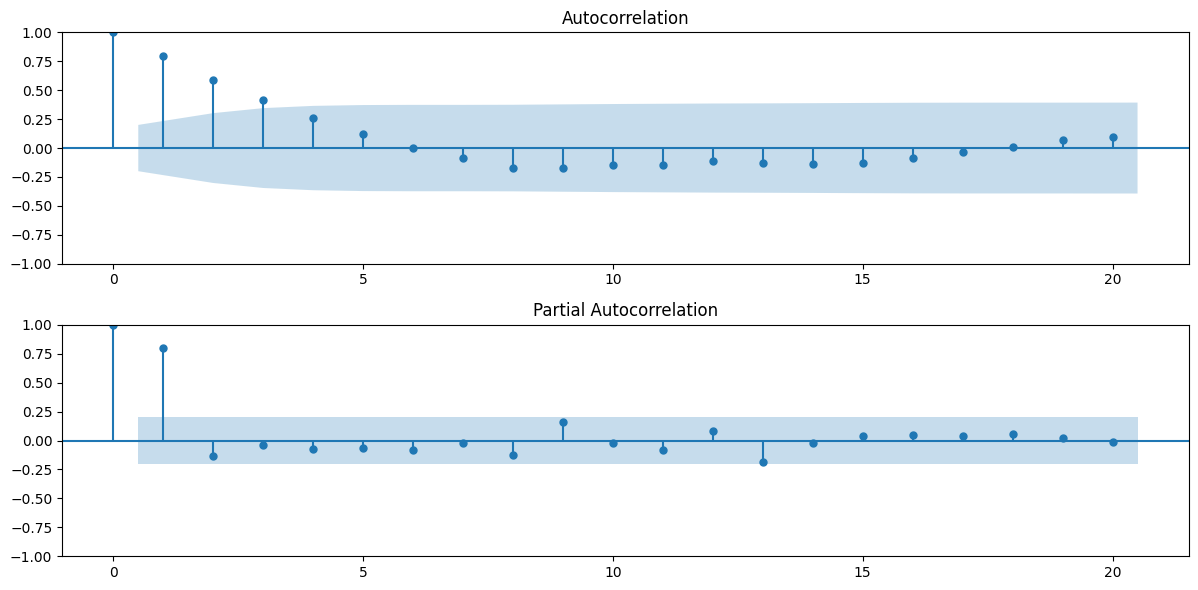

In [376]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plotting the ACF and PACF plots
plt.figure(figsize=(12, 6))

# ACF plot
plt.subplot(211)
plot_acf(yield_data, ax=plt.gca(), lags=20)

# PACF plot
plt.subplot(212)
plot_pacf(yield_data, ax=plt.gca(), lags=20)

plt.tight_layout()
plt.show()

In [377]:
from statsmodels.tsa.arima.model import ARIMA
import warnings

# Fitting an ARIMA(1,0,1) model to the differenced series
# Suppressing warnings for model fitting
warnings.filterwarnings("ignore")

model = ARIMA(yield_data, order=(1, 0, 1))
model_fit = model.fit()

# Displaying the summary of the model
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:         Yield_per_Acre   No. Observations:                   96
Model:                 ARIMA(1, 0, 1)   Log Likelihood                -219.161
Date:                Sat, 30 Dec 2023   AIC                            446.323
Time:                        14:48:54   BIC                            456.580
Sample:                             0   HQIC                           450.469
                                 - 96                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        173.9086      1.109    156.854      0.000     171.736     176.082
ar.L1          0.7504      0.111      6.742      0.000       0.532       0.969
ma.L1          0.1514      0.244      0.619      0.536      -0.328       0.630
sigma2         5.5671      0.539     10.333      0.000       4.511       6.623
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               124.53
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               1.66   Skew:                             0.72
Prob(H) (two-sided):                  0.16   Kurtosis:                         8.39
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [378]:
# Trying different ARIMA configurations to find a better fitting model
# We will vary p and q from 0 to 2 and keep d as 0 since we have already differenced the series once

best_aic = float("inf")
best_bic = float("inf")
best_order = None
best_model = None

# Iterating over different values of p and q
for p in range(3):
    for q in range(3):
        try:
            # Fitting the ARIMA model
            model = ARIMA(yield_data, order=(p, 0, q))
            model_fit = model.fit()

            # Checking if the current model has a lower AIC and BIC than the best so far
            if model_fit.aic < best_aic and model_fit.bic < best_bic:
                best_aic = model_fit.aic
                best_bic = model_fit.bic
                best_order = (p, 0, q)
                best_model = model_fit
        except:
            continue

# Displaying the best model's summary
(best_order, best_model.summary())


((1, 0, 0),
 <class 'statsmodels.iolib.summary.Summary'>
 """
                                SARIMAX Results                                
 Dep. Variable:         Yield_per_Acre   No. Observations:                   96
 Model:                 ARIMA(1, 0, 0)   Log Likelihood                -219.921
 Date:                Sat, 30 Dec 2023   AIC                            445.841
 Time:                        14:49:36   BIC                            453.534
 Sample:                             0   HQIC                           448.951
                                  - 96                                         
 Covariance Type:                  opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
 ------------------------------------------------------------------------------
 const        173.8678      1.214    143.265      0.000     171.489     176.246
 ar.L1          0.8028      0.078     10.318      0.000   

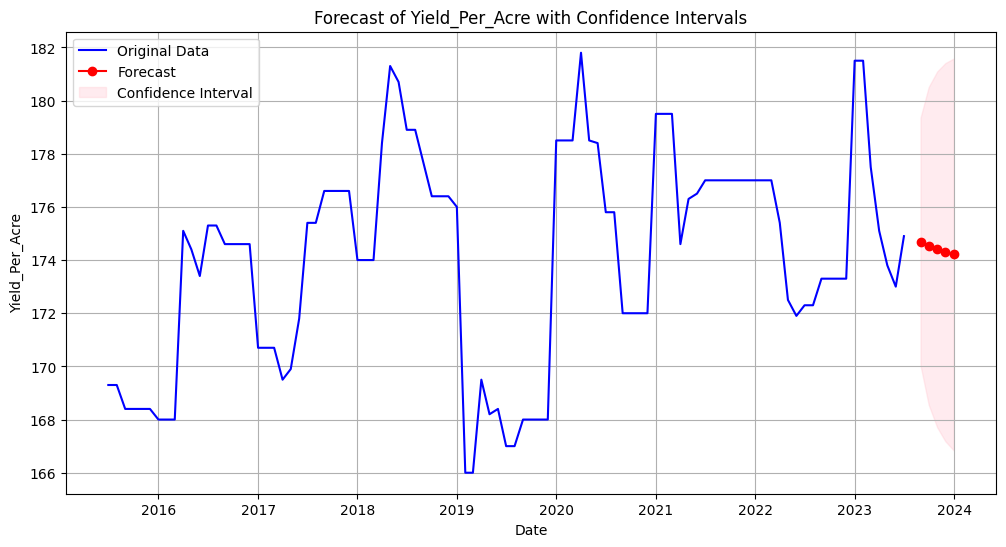

In [381]:
# Proceeding with forecasting using the best model (ARIMA(1,0,0))

# Number of steps to forecast
n_steps = 5

# Forecasting the next few steps
forecast = best_model.get_forecast(steps=n_steps)

# Extracting forecast mean and confidence intervals
forecast_mean = forecast.predicted_mean

# Correcting the approach to get the confidence intervals
confidence_intervals = forecast.conf_int()

# Adjusting the forecast index to align with the original data's timeline

# Getting the last date from the original data
last_date = yield_data.index[-1]

# Generating new forecast dates starting from the day after the last date
forecast_dates = pd.date_range(start=last_date, periods=n_steps + 1, freq='M')[1:]

# Assigning the new dates to the forecast and confidence intervals
forecast_mean.index = forecast_dates
confidence_intervals.index = forecast_dates

# Re-plotting the forecast with the corrected dates
plt.figure(figsize=(12, 6))

# Plotting the original data
plt.plot(yield_data['Yield_per_Acre'], color='blue', label='Original Data')

# Plotting the forecast
plt.plot(forecast_mean, color='red', marker='o', label='Forecast')

# Plotting the confidence intervals
plt.fill_between(confidence_intervals.index, 
                 confidence_intervals['lower Yield_per_Acre'], 
                 confidence_intervals['upper Yield_per_Acre'], 
                 color='pink', alpha=0.3, label='Confidence Interval')

plt.title('Forecast of Yield_Per_Acre with Confidence Intervals')
plt.xlabel('Date')
plt.ylabel('Yield_Per_Acre')
plt.legend()
plt.grid(True)
plt.show()


In [382]:
forecast_mean

2023-08-31    174.696404
2023-09-30    174.532965
2023-10-31    174.401764
2023-11-30    174.296442
2023-12-31    174.211893
Freq: M, Name: predicted_mean, dtype: float64

In [384]:
most_recent[['Marketing_Year_Month','projected_dates','Yield_per_Acre']]

Marketing_Year_Month             2023-08-01
projected_dates         2023-12-01 00:00:00
Yield_per_Acre                        174.9
Name: 0, dtype: object

so we slightly under-estimate yield